## Prepare Libraries and Import Data

In [31]:
!pip install transformers

In [32]:
!pip install datasets

In [33]:
!pip install accelerate

In [34]:
!pip install jsonlines

In [35]:
import torch
if torch.cuda.is_available():
    device_name = torch.device("cuda")
else:
    device_name = torch.device('cpu')
print("Using {}.".format(device_name))

Using cpu.


In [36]:
from datasets import load_dataset
from datasets import load_metric
from datasets import Dataset, DatasetDict
import accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import jsonlines
import pandas as pd
import numpy as np

In [37]:
# import data

data = pd.read_csv("/content/drive/MyDrive/DATA 495/segmented_df.csv")

In [38]:
# identify unnecessary columns
data.columns

Index(['Unnamed: 0', 'Date', 'Title', 'Segmented_Transcript', 'Polarity',
       'Polarity_Numeric'],
      dtype='object')

In [39]:
# drop columns
columns_to_drop = ['Unnamed: 0', 'Date', 'Title', 'Polarity_Numeric']
data = data.drop(columns_to_drop, axis=1)

In [40]:
data.columns

Index(['Segmented_Transcript', 'Polarity'], dtype='object')

In [41]:
data.head()

,Segmented_Transcript,Polarity
0,"Vladimir Putin: Good afternoon, distinguished ...",pos
1,mutually beneficial cooperation. Russia will ...,pos
2,hey should continue doing their job and carryi...,pos
3,the Security Council and the Russian Governmen...,pos
4,osecutor-General’s Office to strengthen contro...,pos


In [42]:
data.Polarity.value_counts()

pos    97989
neg      229
Name: Polarity, dtype: int64

## Balance Data through Random Undersampling and SMOTE

In [43]:
!pip install imbalanced-learn


In [44]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler

# Assuming df is your DataFrame
# Display the original class distribution
print("Original Class Distribution:")
print(data['Polarity'].value_counts())

# Separate features and target variable
X = data.drop('Polarity', axis=1)
y = data['Polarity']

# Instantiate the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Undersample the majority class
X_resampled, y_resampled = rus.fit_resample(X, y)

# Create a new balanced DataFrame
df_balanced = pd.concat([X_resampled, y_resampled], axis=1)

# Display the balanced class distribution
print("\nBalanced Class Distribution:")
print(df_balanced['Polarity'].value_counts())


Original Class Distribution:
pos    97989
neg      229
Name: Polarity, dtype: int64

Balanced Class Distribution:
neg    229
pos    229
Name: Polarity, dtype: int64


In [45]:
df_balanced.head()

,Segmented_Transcript,Polarity
0,Vladimir Putin: We have two events planned her...,neg
1,"rtheless, we still have a lot of challenges to...",neg
2,ed to use the Chechen people for their extremi...,neg
3,Question: You have spent the last four days wo...,neg
4,"religious makeup. Unfortunately, in the south...",neg


In [46]:
# Save df_balanced to disk
df_balanced.to_csv('/content/drive/MyDrive/DATA 495/balanced_df.csv')

In [47]:
# load df_balanced as hugging face dataset
data = load_dataset('csv', data_files='/content/drive/MyDrive/DATA 495/balanced_df.csv')

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [48]:
data

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Segmented_Transcript', 'Polarity'],
        num_rows: 458
    })
})

## Tokenize Dataset

In [49]:
# load tokenizer and model, create trainer
model_name = "j-hartmann/sentiment-roberta-large-english-3-classes"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.to(device_name)
trainer = Trainer(model=model)

Some weights of the model checkpoint at j-hartmann/sentiment-roberta-large-english-3-classes were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [50]:
# rename polarity column to labels
data = data.rename_column("Polarity", "labels")

In [51]:
# convert labels to int
data = data.class_encode_column("labels")

Casting to class labels:   0%|          | 0/458 [00:00<?, ? examples/s]

In [52]:
# check to make sure it worked
df = data["train"].to_pandas()
df['labels'].value_counts()

0    229
1    229
Name: labels, dtype: int64

In [53]:
# Define a function to tokenize a specific column
def tokenize_column(batch):
    return tokenizer(batch['Segmented_Transcript'], padding=True, truncation=True)

In [54]:
# tokenize entire dataset
data_tokenized = data.map(tokenize_column, batched=True)

Map:   0%|          | 0/458 [00:00<?, ? examples/s]

In [61]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Segmented_Transcript', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 458
    })
})

In [62]:
# 90% train, 10% test + validation
split_data_tokenize = data_tokenized['train'].train_test_split(test_size=0.1)

In [63]:
# Split the 10% test + valid in half test, half valid
test_tokenize = split_data_tokenize['test'].train_test_split(test_size=0.3)

In [64]:
# gather everyone if you want to have a single DatasetDict
data_tokenized = DatasetDict({
    'train': split_data_tokenize['train'],
    'test': test_tokenize['test'],
    'valid': test_tokenize['train']})

In [65]:
data_tokenized

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'Segmented_Transcript', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 412
    })
    test: Dataset({
        features: ['Unnamed: 0', 'Segmented_Transcript', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 14
    })
    valid: Dataset({
        features: ['Unnamed: 0', 'Segmented_Transcript', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 32
    })
})

In [72]:
# save data_tokenized to disk
data_tokenized.save_to_disk('/content/drive/MyDrive/DATA 495/data_tokenized')

Saving the dataset (0/1 shards):   0%|          | 0/412 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/14 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/32 [00:00<?, ? examples/s]

## Train using Balanced Dataset

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 1.3 MB/s eta 0:00:00


### Prepare Metrics

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds)

    # Convert NumPy arrays to lists
    precision = precision.tolist()
    recall = recall.tolist()
    f1 = f1.tolist()

    acc = accuracy_score(labels, preds)

    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)

    # Convert the confusion matrix to a DataFrame for better visualization
    cm_df = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

    # Visualize the confusion matrix using seaborn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }


In [ ]:
# log into hugging face hub
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer, TrainingArguments

batch_size = 16
logging_steps = len(data_tokenized['train']) // batch_size
model_name = "j-hartmann/sentiment-roberta-large-english-3-classes"
training_args = TrainingArguments( output_dir = model_name,
                                  num_train_epochs = 4,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error"
                                   )

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_tokenized['train'],
    eval_dataset=data_tokenized['test'],
    tokenizer=tokenizer
)

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.872700,0.489233,0.785714,"[0.6666666666666665, 0.8421052631578948]","[0.75, 0.8]","[0.6, 0.8888888888888888]"
2,0.436400,0.506704,0.642857,"[0.6666666666666666, 0.6153846153846153]","[0.5, 1.0]","[1.0, 0.4444444444444444]"
3,0.228400,0.551108,0.714286,"[0.6666666666666666, 0.75]","[0.5714285714285714, 0.8571428571428571]","[0.8, 0.6666666666666666]"
4,0.080300,0.513085,0.714286,"[0.6666666666666666, 0.75]","[0.5714285714285714, 0.8571428571428571]","[0.8, 0.6666666666666666]"


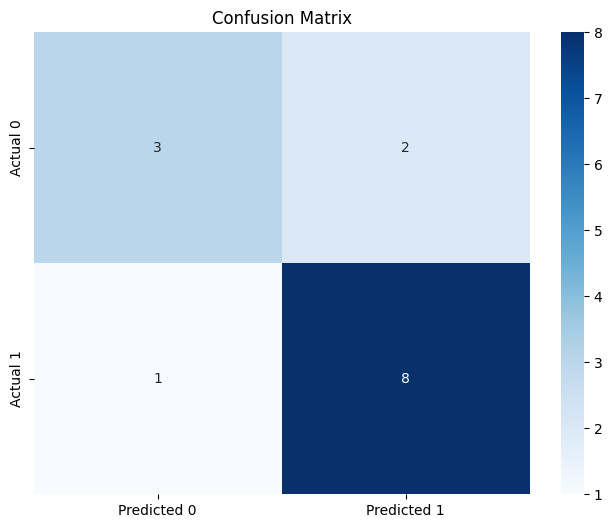

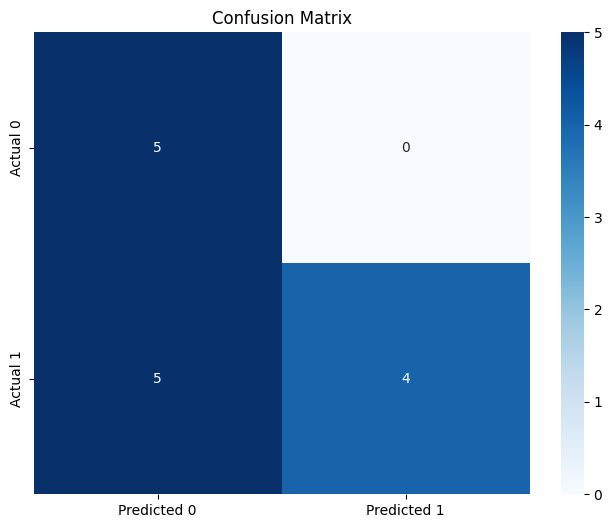

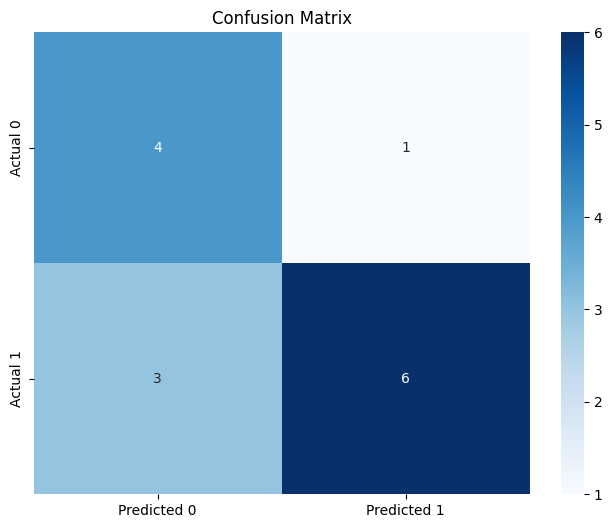

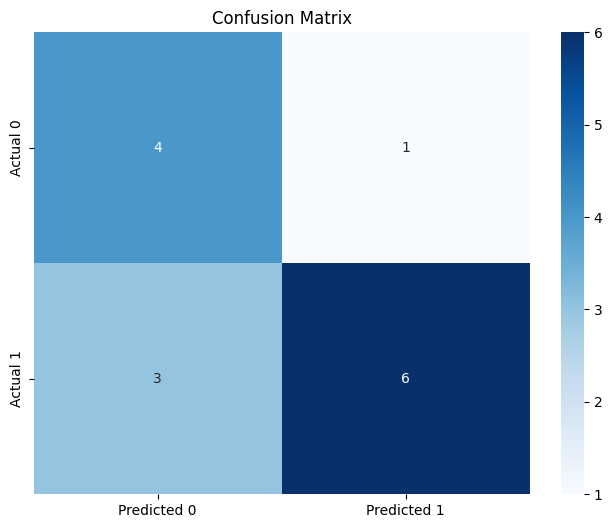

TrainOutput(global_step=104, training_loss=0.39147643687633366, metrics={'train_runtime': 47.6079, 'train_samples_per_second': 34.616, 'train_steps_per_second': 2.185, 'total_flos': 431951646371328.0, 'train_loss': 0.39147643687633366, 'epoch': 4.0})

In [ ]:
trainer.train()

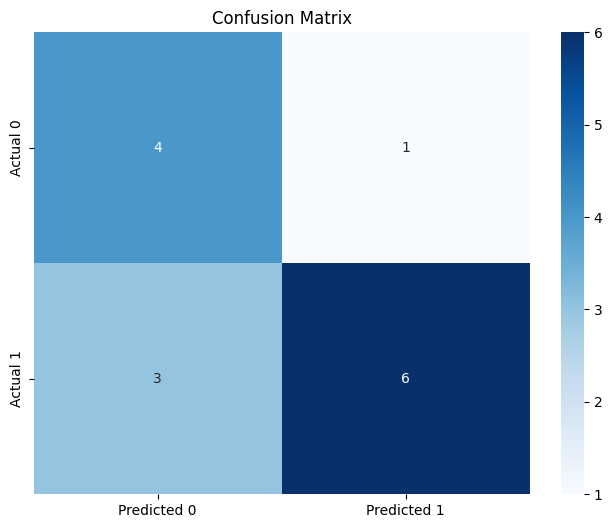

{'eval_loss': 0.5130845308303833,
 'eval_accuracy': 0.7142857142857143,
 'eval_f1': [0.6666666666666666, 0.75],
 'eval_precision': [0.5714285714285714, 0.8571428571428571],
 'eval_recall': [0.8, 0.6666666666666666],
 'eval_runtime': 0.3004,
 'eval_samples_per_second': 46.599,
 'eval_steps_per_second': 3.329,
 'epoch': 4.0}

In [ ]:
trainer.evaluate()

In [ ]:
trainer.save_model("/content/drive/MyDrive/DATA 495/trained_3sentiment_model")


events.out.tfevents.1700848132.1d914dfbda74.893.2:   0%|          | 0.00/5.11k [00:00<?, ?B/s]

events.out.tfevents.1700848977.1d914dfbda74.893.3:   0%|          | 0.00/4.64k [00:00<?, ?B/s]

Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.66k [00:00<?, ?B/s]

## Fine-Tune Model


In [ ]:
# empty memory
torch.cuda.empty_cache()

In [ ]:
! pip install optuna

During hyperparameter search, the Trainer will run several trainings, so it needs to have the model defined via a function (so it can be reinitialized at each new run) instead of just having it passed. We jsut use the same function as before:


In [ ]:
# import model we just trained and saved
model_checkpoint = "/content/trained_3sentiment_model"

In [ ]:
# define function to reinitialize model for each pass through
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

In [ ]:
# define the metric we're looking to optimize (accuracy)


def compute_single_metric(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate accuracy
    acc = accuracy_score(labels, preds)

    return {'accuracy': acc}


In [ ]:
# convert it to optuna single metric
def objective(metrics):
    return metrics['accuracy']


In [ ]:
# redefine training arguments
batch_size = 4
args = TrainingArguments( output_dir = model_name,
                                  num_train_epochs = 4,
                                  learning_rate = 2e-5,
                                  per_device_train_batch_size = batch_size,
                                  per_device_eval_batch_size = batch_size,
                                  weight_decay = 0.01,
                                  evaluation_strategy = "epoch",
                                  metric_for_best_model='accuracy',
                                  disable_tqdm = False,
                                  logging_steps = logging_steps,
                                  push_to_hub = True,
                                  log_level = "error"
                                   )

In [ ]:
# define Trainer function

trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=data_tokenized["train"],
    eval_dataset=data_tokenized["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_single_metric
)

OutOfMemoryError: ignored

In [ ]:
train_dataset = data_tokenized["train"].shard(index=1, num_shards=10)

In [ ]:
# optuna training function

best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")


[I 2023-11-24 18:04:47,709] A new study created in memory with name: no-name-a75c95a7-30a7-4fa4-8023-ea024c4b4604
[W 2023-11-24 18:04:50,517] Trial 0 failed with parameters: {'learning_rate': 2.8081948802948824e-06, 'num_train_epochs': 1, 'seed': 34, 'per_device_train_batch_size': 8} because of the following error: OutOfMemoryError('CUDA out of memory. Tried to allocate 198.00 MiB. GPU 0 has a total capacty of 15.77 GiB of which 8.12 MiB is free. Process 8226 has 15.76 GiB memory in use. Of the allocated memory 14.08 GiB is allocated by PyTorch, and 477.71 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.10/dist-packages/transf

OutOfMemoryError: ignored

[I 2023-11-24 17:48:48,862] A new study created in memory with name: no-name-e47218b6-178d-40a6-b94d-433947cbde17


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.079200,0.820738,0.812500,"[0.8571428571428572, 0.7272727272727272]","[0.8181818181818182, 0.8]","[0.9, 0.6666666666666666]"


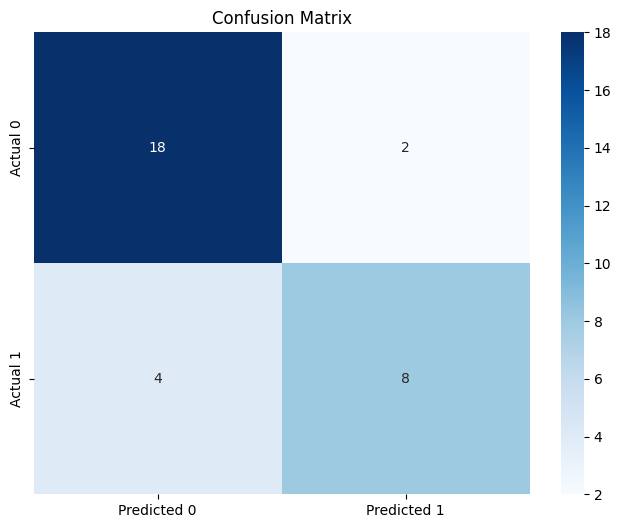

[W 2023-11-24 17:49:04,070] Trial 0 failed with parameters: {'learning_rate': 6.993168810384119e-06, 'num_train_epochs': 5, 'seed': 31, 'per_device_train_batch_size': 16} because of the following error: TypeError("unsupported operand type(s) for +: 'float' and 'list'").
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "/usr/local/lib/python3.10/dist-packages/transformers/integrations/integration_utils.py", line 195, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1546, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1937, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/tran

TypeError: ignored

In [ ]:
# look for best run on a variety of hyperparameters

best_run = trainer.hyperparameter_search(n_trials=10, direction="maximize")